In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/My Drive/Trabajo de Grado 2


In [0]:
ls

Backup/            CCN_ResNet50.ipynb  dataset/  Trabajo_de_Grado_CCN.ipynb
cancer_mnist.h5py  CCN_VGG16.ipynb     Pruebas/


# Importar Librerías

In [0]:
%matplotlib inline
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


# Cargar Set de Imágenes

In [0]:
dirname = os.path.join(os.getcwd(), 'dataset')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))


leyendo imagenes de  /content/drive/My Drive/Trabajo de Grado 2/dataset/
/content/drive/My Drive/Trabajo de Grado 2/dataset/malignos 1
/content/drive/My Drive/Trabajo de Grado 2/dataset/benignos 1497
Directorios leidos: 2
Imagenes en cada directorio [1498, 1799]
suma Total de imagenes en subdirs: 3297


# Creamos las etiquetas

In [0]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad Etiquetas Creadas: ",len(labels))

lunar_cancer=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    lunar_cancer.append(name[len(name)-1])
    indice=indice+1
    
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy


Cantidad Etiquetas Creadas:  3297
0 malignos
1 benignos


# Encuentra los números únicos de la etiquetas a entrenar

In [0]:
classes = np.unique(y)
nClasses = len(classes)
print('Total Numero de Salidas : ', nClasses)
print('Clases de Salida : ', classes)

Total Numero de Salidas :  2
Clases de Salida :  [0 1]


# Creamos Sets de Entrenamiento y Test

In [0]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Forma de los datos de entrenamiento : ', train_X.shape, train_Y.shape)
print('Forma de los datos de prueba : ', test_X.shape, test_Y.shape)

plt.figure(figsize=[5,5])

Forma de los datos de entrenamiento :  (2637, 224, 224, 3) (2637,)
Forma de los datos de prueba :  (660, 224, 224, 3) (660,)


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

# Mostrar la primera imagen en Datos de entrenamiento.

Text(0.5, 1.0, 'Verdad Fundamental: 1')

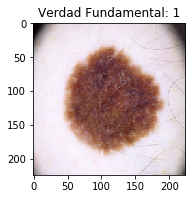

In [0]:
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Verdad Fundamental: {}".format(train_Y[0])) ## 

# Mostrar la primera imagen en los datos de entrenamiento.

Text(0.5, 1.0, 'Verdad Fundamental : 0')

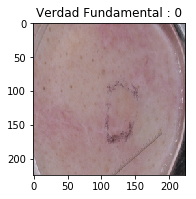

In [0]:
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Verdad Fundamental : {}".format(test_Y[0])) 

# Preprocesamos las imagenes

In [0]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Hacemos la Codificación One-Hot para la red

In [0]:
# Cambiar las etiquetas de categóricas a una codificación en caliente (one-hot encoding)
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Mostrar el cambio para la etiqueta de categoría usando la codificación de un solo uso (one-hot encoding)
print('Etiqueta original:', train_Y[0])
print('Después de la conversión a one-hot:', train_Y_one_hot[0])


Etiqueta original: 1
Después de la conversión a one-hot: [0. 1.]


# Creamos el Set de Entrenamiento y Validación

In [0]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
[ ]

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(2109, 224, 224, 3) (528, 224, 224, 3) (2109, 2) (528, 2)


# ***Creamos el Modelo de CNN, DP 0.25 dense, RELU y Kernel 64***

In [0]:
#Declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 50 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento 50
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria 64

In [0]:
#Primera Capa de Entrada
cancer_model = Sequential()
cancer_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',strides=(1),input_shape=(224,224,3)))
cancer_model.add(MaxPooling2D((2, 2),padding='same'))
#cancer_model.add(Dropout(0.25))   

#Segunda Capa Oculta
cancer_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',strides=(1),input_shape=(112,112,3)))
cancer_model.add(MaxPooling2D((2, 2),padding='same'))
#cancer_model.add(Dropout(0.25))

#Tercera Capa Oculta
cancer_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',strides=(1),input_shape=(56,56,3)))  
cancer_model.add(MaxPooling2D((2, 2),padding='same'))
#cancer_model.add(Dropout(0.25))

#Cuarta Capa Oculta
cancer_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',strides=(1),input_shape=(28,28,3)))  
cancer_model.add(MaxPooling2D((2, 2),padding='same'))
#cancer_model.add(Dropout(0.25))

#Quinta Capa Oculta
cancer_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',strides=(1),input_shape=(14,14,3))) 
cancer_model.add(MaxPooling2D((2, 2),padding='same'))
#cancer_model.add(Dropout(0.25))

#Capa Salida
cancer_model.add(Flatten())
cancer_model.add(Dense(64, activation='relu'))
cancer_model.add(Dropout(0.25))
cancer_model.add(Dense(nClasses, activation='softmax'))

cancer_model.summary()

cancer_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=INIT_LR),metrics=['accuracy'])

W0827 03:35:20.757701 140145586259840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 03:35:20.805536 140145586259840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 03:35:20.815089 140145586259840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 03:35:20.851920 140145586259840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0827 03:35:20.937670 140145586259840 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        36928     
__________

# Entrenamos el modelo: Aprende a Clasificar Imágenes

In [0]:
# Este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre tarda 5 minutos
cancer_train = cancer_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

# Evaluamos la Red

660/660 [==============================] - 2s 3ms/step
Perdida(loss) de Prueba: 0.5257269978523255
Exactitud(accuracy) de Prueba: 0.8393939390326991


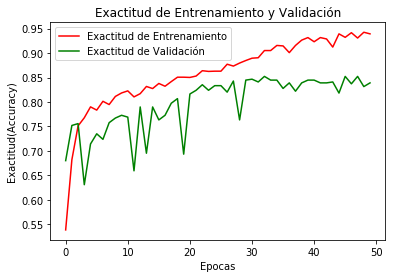

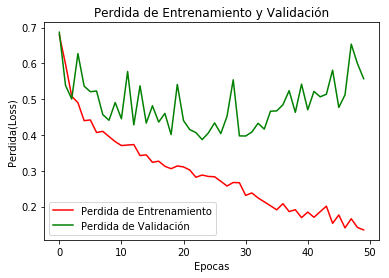

((660,), (660,))

In [0]:
test_eval = cancer_model.evaluate(test_X, test_Y_one_hot, verbose=1)

print('Perdida(loss) de Prueba:', test_eval[0])
print('Exactitud(accuracy) de Prueba:', test_eval[1])

accuracy = cancer_train.history['acc']
val_accuracy = cancer_train.history['val_acc']
loss = cancer_train.history['loss']
val_loss = cancer_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Exactitud de Entrenamiento')
plt.plot(epochs, val_accuracy, 'g', label='Exactitud de Validación')
plt.title('Exactitud de Entrenamiento y Validación')
plt.xlabel('Epocas')
plt.ylabel('Exactitud(Accuracy)')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Perdida de Entrenamiento')
plt.plot(epochs, val_loss, 'g', label='Perdida de Validación')
plt.title('Perdida de Entrenamiento y Validación')
plt.xlabel('Epocas')
plt.ylabel('Perdida(Loss)')
plt.legend()
plt.show()

predicted_classes2 = cancer_model.predict(test_X)

predicted_classes=[]
for predicted_cancer in predicted_classes2:
    predicted_classes.append(predicted_cancer.tolist().index(max(predicted_cancer)))
predicted_classes=np.array(predicted_classes)

predicted_classes.shape, test_Y.shape

# Aprendamos de los Errores: Qué Mejorar

Encontraron 554 Etiquetas Correctas


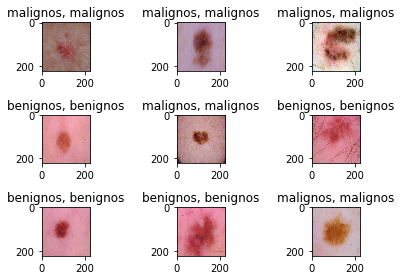

In [0]:
correct = np.where(predicted_classes==test_Y)[0]
print("Encontraron %d Etiquetas Correctas" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(224,224,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(lunar_cancer[predicted_classes[correct]],
                                                    lunar_cancer[test_Y[correct]]))

    plt.tight_layout()

Encontraron 106 Etiquetas Incorrectas


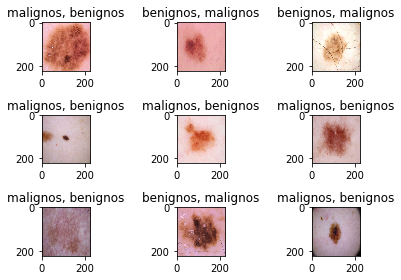

In [0]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Encontraron %d Etiquetas Incorrectas" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(224,224,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(lunar_cancer[predicted_classes[incorrect]],
                                                    lunar_cancer[test_Y[incorrect]]))
    plt.tight_layout()

In [0]:
target_names = ["Clase {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Clase 0       0.78      0.88      0.83       292
     Clase 1       0.90      0.80      0.85       368

    accuracy                           0.84       660
   macro avg       0.84      0.84      0.84       660
weighted avg       0.85      0.84      0.84       660

